In [ ]:
#In this block we define the functions that we use to price the derivatives

from numpy.lib.shape_base import kron
import numpy as np 
import time
import matplotlib.pyplot as plt 
import statsmodels.api as sm


def zero_coupon_bond(r, F, Delta, T):
  #function to calculate the price of a zero coupon bond
  return np.exp(-r*Delta*T) * F 

def standard_coupon_bond(r, F, Delta, T, c, coupon_dates):
  #coupon_dates is a list of dates 
  x = 0 
  #summing up the value of coupon discounted 
  for t in coupon_dates:
    x = x + zero_coupon_bond(r, c*F, Delta, t)
  
  #summing up the facevalue discounted 
  x = x + zero_coupon_bond(r, F, Delta, T)
  return x 
   
    
def call(price, k):
    return np.maximum(price-k, 0 )


def put(price, k ):
    return np.maximum(k-price, 0)

def onestep_price(v, q):
    #this function is used to get the expected value, based on the probability q of the nodes of the tree in a 
    #convenient and fast way using vectors 
    v1 = v[0:len(v) - 1]
    v2 = v[1:len(v)]
    return q*v1 + (1-q)*v2

      
#we can replace calculate terminal stock with this 
def calculate_terminal_stock(s0, u, d, T, div_yield, dividend_dates):
   
   if div_yield == 0  or len(dividend_dates) == 0:   #case where dividend_yield == 0 or dividend_dates is an empty list 
    terminal =  s0 * u**np.array([range(T,-1,-1)]) * d**np.array([range(0,T+1)]) 
    return terminal.transpose()
  
   else: 
     terminal =  s0 * u**np.array([range(T,-1,-1)]) * d**np.array([range(0,T+1)]) 
     return terminal.transpose() * (1-div_yield)**len(dividend_dates)


def european(s0, function,k, T, r, Delta, u, d, div_yield,dividend_dates):
  
    q = (np.exp(r * Delta) - d )/(u-d)  #computing the EMM probability 
    disc = np.exp( - r * Delta )  #discounting factor 
    terminal_stock_values = calculate_terminal_stock(s0,u,d,T, div_yield, dividend_dates)   #vector of terminal stock values 
    terminal_value_derivative = function(terminal_stock_values, k)    #applying the derivative function to these prices 
  
    for j in range(T):  #now we go back in the tree by computing the expected values and discounting  
        if j == 0:
            v = onestep_price(terminal_value_derivative, q) * disc
        else:
            v = onestep_price(v, q) * disc 
     
    return v.item()     #we return the initial price of the given european derivative



def payoff_american(T, t, stock_price, F, gamma, r, Delta, future_coupon_dates,c):
     #function that calculates the payoff of the american derivatives at each dates 
      tau = T-t   
      future_coupon_dates_minus_t = [ (l-t) for l in future_coupon_dates]  #here we select the future coupon dates and we subtract t to make it consistent with the date at which we are
      coupon_value = standard_coupon_bond(r, F, Delta, tau, c, future_coupon_dates_minus_t )   #value of the coupon bond
      
      return stock_price - (1/gamma)*coupon_value   #payoff of the american derivative 



def american_for_CB(to_print, s0, F, T, r, Delta, u, d, div_yield,dividend_dates, coupon_dates, gamma, c):
 
    q = (np.exp(r * Delta) - d )/(u-d)   #calculate q probability  
    disc = np.exp( - r * Delta )   #discounting factor   
    terminal_stock_values = calculate_terminal_stock(s0,u,d,T, div_yield, dividend_dates)
    derivative_price = ( terminal_stock_values - F/gamma) * (  ( terminal_stock_values - F/gamma) >= 0 )
   
    #here we need to add that we want to exercise if is bigger than 0 
    exercise = derivative_price > 0 
    if to_print:
        print(optimal_decision_tree(T,exercise)) 
  
    for j in range(0,T):
      
      if T-j-1 in coupon_dates:   #we do our computation only if we are in a coupon dates 
        
        dividend_dates_past = []    #here we select only the dividend dates that are before or equal to the time at which we are on the tree
        for h in dividend_dates: 
          if h <= T-j-1:
              dividend_dates_past.append(h)
        
        coupon_dates_future = []    #here we select only future coupon dates 
        for y in coupon_dates:
          if y > T-j-1:
            coupon_dates_future.append(y)
        

        cont_value = onestep_price(derivative_price, q) * disc      #continuation value 
        stock_values = calculate_terminal_stock(s0, u, d, T-j-1, div_yield, dividend_dates_past)  #stock values 
        payoff = payoff_american(T, T-j-1, stock_values, F, gamma, r, Delta, coupon_dates_future, c)   #payoff of the american 
          
        exercise = np.round(payoff,8) >= np.round(cont_value,8)   #we exercise only if the payoff is larger than the continuation value 
       
        if exercise.sum() >= 1: 
          if to_print:
              print(optimal_decision_tree(T-j-1,exercise))       #print the optimal choice 
          
        derivative_price = exercise * payoff + np.invert(exercise) * cont_value       #np.invert gives !exercise    the price here is given by the payoff where is optimal to exercise 
                                                                                      #and is given by the continuation value where is not optimal to exercise 
      
      else:
        derivative_price = onestep_price( derivative_price, q) * disc     #if we are not in a coupon date we take the continuation value 
        
      
    return derivative_price.item()  

#exercise_choice is a list containing in the value True the nodes at which you need to exercise 


def optimal_decision_tree(t,exercise):   #function used to print out optimal decisions

    tree_element = list( map (change_name, exercise.flatten().tolist() ) )    
    x = np.array(tree_element)
    index = np.where(x == "Exercise")[0] 
    name = name_nodes(t,index.tolist())
    name = np.array([name]).transpose()
    result = f"\nAt time {t} exercise at nodes:  \n{name} "   #we return what we need to print 
    return result 
  


def name_nodes(t, index):    #function used to print out name of the nodes using a n_U U - n_D - D notation
    name = []
    for k in index:
      if k > 0:
       name.append(f"{(t-k)}U-{k}D")
      else:
       name.append(f"{(t-k)}U")

    return name 


def change_name(s):    #function used to get exercise choice 
   if s == False:
      return "Do not exercise"
   else: return "Exercise"


def change_name_2(s):   #function used to get the optimal choice of holder when the issuer exercise
    if s == True:
      return "Stock"
    else:
      return "Money"




def mCB(T, Delta, r, s0, coupon_dates, dividend_dates, div_yield, u, d, F, c, alpha, beta, gamma):
  
    if alpha < beta:    #checking a basic error
      return "Error: Impossible have alpha smaller than beta"

    initial_price_bond = standard_coupon_bond(r, F, Delta, T, c, coupon_dates)  #standard coupon price 
    strike_call = F/beta   #define the two strikes
    strike_put = F/alpha
    initial_price_call = european(s0, call, strike_call, T, r, Delta , u, d, div_yield, dividend_dates)
    initial_price_put = european(s0, put, strike_put, T, r, Delta , u, d, div_yield, dividend_dates)

    return initial_price_bond + beta * initial_price_call - alpha * initial_price_put   #returning the initial price




def CB(to_print, s0, F, T, r, Delta, u, d, div_yield,dividend_dates, coupon_dates, gamma, c):
    
    initial_price_bond = standard_coupon_bond(r, F, Delta, T, c, coupon_dates)   #price of the  bond 
    initial_american_price = american_for_CB(to_print, s0, F, T, r, Delta, u, d, div_yield,dividend_dates, coupon_dates, gamma, c)   #price of the american derivatove 
    
    return initial_price_bond + gamma * initial_american_price   #we return the price 


def cCB(to_print, s0, F, T, r, Delta, u, d, div_yield,dividend_dates, coupon_dates, gamma, c, F_c):
    
    #At the terminal time we have that the continuation value is given by F, that is the face value of the bond 
    #therefore we have that 
    q = (np.exp(r * Delta) - d )/(u-d)
    disc = np.exp( - r * Delta )   #discounting factor  

    #here we compute all the calculation for the terminal time and then we use a for loop 

    terminal_stock_values = calculate_terminal_stock(s0,u,d,T, div_yield, dividend_dates)   #stock at the terminal time 
    cont_value = F * np.ones( terminal_stock_values.shape )    #continuation value 
    Fc = F_c * np.ones( terminal_stock_values.shape )      #vector of call price 
    maximum_Fc_stock = np.maximum(Fc,gamma * terminal_stock_values)
    maximum_cont_stock = np.maximum(cont_value,gamma * terminal_stock_values)

    seller_exercise = np.round(cont_value,8) > np.round(maximum_Fc_stock,8)     #array of true and false following the optimal rule described in the pdf 

    if seller_exercise.sum() >= 1:   #if the issuer, called seller, exercise in some nodes we want to see where 
      if to_print:
        print(f"ISSUER:  {optimal_decision_tree(T, seller_exercise)}")          
        holder = list(map(change_name_2, gamma*terminal_stock_values >= Fc))
        print(f"HOLDER DECISION:   At time {T}  {np.take(holder ,np.where(seller_exercise == True)[0].tolist() ).tolist()}")    
    
    #here we want to see where the holder exercise
    holder_exercise = np.round(gamma * terminal_stock_values,8) >= np.round(cont_value,8)  #array of true and false

    if np.take( holder_exercise, np.where(seller_exercise==False)[0].tolist() ).sum() >= 1:
      if to_print:
        print(f"HOLDER:  {optimal_decision_tree(T, holder_exercise)}")       
                                                                                              
    price = seller_exercise * maximum_Fc_stock + np.invert(seller_exercise) * maximum_cont_stock   #price of the security
    
    #now we need to compute the price of all the previous dates 
    for j in range(0, T):
      
      if T-j-1 in coupon_dates:
     
        if to_print:
          print("\n")
        #here we need to compute the continuation value using the precendet price saved in the variable price
        #the other passages are the same as before
        #as before we need to modify the list of dividend and copuon dates 
        dividend_dates_past = []
        for h in dividend_dates:
            if h <= T-j-1:
                dividend_dates_past.append(h)
        
        stock_values = calculate_terminal_stock(s0, u, d, T-j-1, div_yield, dividend_dates_past)

                                                        
        if T-j in coupon_dates:    #T-j is t+1           #we divide the case in which t+1 is a coupon date because it will change the cont value 
          cont_value = onestep_price(price , q) * disc + c*F*disc
         
        else:
          cont_value = onestep_price(price, q) * disc 
          
        Fc = F_c * np.ones( stock_values.shape ) 
        maximum_Fc_stock = np.maximum(Fc, gamma * stock_values)
        maximum_cont_stock = np.maximum(cont_value, gamma * stock_values)
       
        seller_exercise = np.round(cont_value,8) > np.round(maximum_Fc_stock,8)  #array of true and false:
     
        if seller_exercise.sum() >= 1:
          if to_print:
            print(f"ISSUER:  {optimal_decision_tree(T-j-1, seller_exercise)}") 
            holder = list(map(change_name_2, gamma*stock_values >= Fc))
            print(f"HOLDER DECISION:   At time {T-j-1}  {np.take(holder ,np.where(seller_exercise == True)[0].tolist() ).tolist()}\n")
            

        holder_exercise = np.round(gamma * stock_values,8) >= np.round(cont_value,8)
      

        if np.take(holder_exercise, np.where(seller_exercise==False)[0].tolist()).sum() >= 1:
          if to_print:
           print(f"HOLDER:  {optimal_decision_tree(T-j-1, holder_exercise)  }")        
        
        price = seller_exercise * maximum_Fc_stock + np.invert(seller_exercise) * maximum_cont_stock
        
      else:
        price = onestep_price(price , q) * disc +  c *F * disc * (T-j in coupon_dates)
        
    return price.item()


#main function to call 

def main( security, s0, F, T, r, Delta, u, d, div_yield,dividend_dates, coupon_dates, gamma, c, *args):
    
    if security == "mCB":     #please put the args that are used only in a specific case at the end in the case of mCB at the end alpha and beta
      alpha, beta = args
      return mCB( T, Delta, r, s0, coupon_dates, dividend_dates, div_yield, u, d, F, c, alpha, beta, gamma)
   
    if security == "CB":
      to_print = args
      to_print = to_print[0]
      return CB(to_print, s0, F, T, r, Delta, u, d, div_yield,dividend_dates, coupon_dates, gamma, c)
   
    if security == "cCB":
      F_c, to_print = args
      return cCB(to_print, s0, F, T, r, Delta, u, d, div_yield,dividend_dates, coupon_dates, gamma, c, F_c)



/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#model calibration - question 4.2  

s0 = 175
data = np.loadtxt('data.dat', unpack = True).transpose()  #upload the file provided with the prices 
strike = data[:,0]                            #strike from the file
call_, put_ = data[:,1], data[:,2]    #call and put prices 
y = call_ - put_ - s0                 #we define y as explained in the pdf to do the regression 
strike_reg = sm.add_constant(strike)     #adding a constant 

#fit linear regression model
model = sm.OLS(y, strike_reg).fit()

alpha, beta = model.params   #getting estimations of parameters  

delta = -alpha / s0     #delta calibrated 
r = -np.log(-beta)      #interest rate calculated  
print(f"Delta: {delta}, Discount rate: {r}")

delta = delta.item()        
r = r.item()


Delta: 0.02955446214306237, Discount rate: 0.049999997109969004


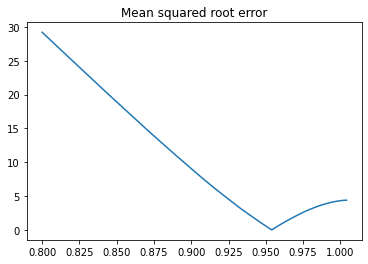

U:   1.0543877054960336
D:   0.9539630126025205


In [ ]:
#now in this block we calibrate the binomial model - point 4.3

Delta = 1/12
U = lambda  d : (np.exp(r * (Delta))  - d/2) * 2   #we define a lambda function to calculate the U corresponding to D
errors = []   
x = np.linspace( 0.8,1.0041, 5000)   #we do a grid search  and we choose calibration precision rather than speed in this case 

for i in x:    #we go through all security price and we minimize the Mean squared error 
  e = 0
  for j in range(0,16):
    est = european(175, call, strike[j], 12, r, Delta, U(i), i, delta, [12])
    e = e + ( call_[j] - est )**2
  
  errors.append(np.sqrt(e/16))    


plt.plot(x, errors)
plt.title("Mean squared root error")
plt.show()


D = x[np.argmin(errors)]   #we take the value of D that minimize the mean squared error 
U = U(D)
print("U:  ", U)
print("D:  ", D)



In [ ]:
#Part 5 - Analysis 

U = 1.0543877054960336   #values optained from the function before 
D =  0.9539651321710724   

F = 1000     
T = 60
coupon_dates = [6,12,18,24,30,36,42,48,54,60]
div_dates = [12,24,36,48,60]
c = 0.02
alpha = 1000
beta = 4
gamma = 4
Fc = 1050
Delta = 1/12


print("MANDATORY CONVERTIBLE BOND")
mandatory_CB = main("mCB", 175, F, T, r, Delta, U, D, delta ,div_dates, coupon_dates, gamma, c, alpha, beta)
print(f"mCB price:  {mandatory_CB}")
print("\n\n----------------------------------------------------------\n\n")

print("VANILLA CONVERTIBLE BOND")
vanilla_CB = main("CB", 175, F, T, r, Delta, U, D, delta ,div_dates, coupon_dates, gamma, c, True)   #getting the price we are asked, if you want only the price 
#and not the explanation of the optimal policy set the last parameter to False 
print(f"CB price:  {vanilla_CB}")

print("\n\n----------------------------------------------------------\n\n")

print("CALLABLE CONVERTIBLE BOND")
call_CB = main("cCB", 175, F, T, r, Delta, U, D, delta ,div_dates, coupon_dates, gamma, c, Fc, True)   #if you want only the price of the security set the last parameter to False 
print(f"cCB price:  {call_CB}")




MANDATORY CONVERTIBLE BOND
mCB price:  993.6687588097367


----------------------------------------------------------


VANILLA CONVERTIBLE BOND

At time 60 exercise at nodes:  
[['60U']
 ['59U-1D']
 ['58U-2D']
 ['57U-3D']
 ['56U-4D']
 ['55U-5D']
 ['54U-6D']
 ['53U-7D']
 ['52U-8D']
 ['51U-9D']
 ['50U-10D']
 ['49U-11D']
 ['48U-12D']
 ['47U-13D']
 ['46U-14D']
 ['45U-15D']
 ['44U-16D']
 ['43U-17D']
 ['42U-18D']
 ['41U-19D']
 ['40U-20D']
 ['39U-21D']
 ['38U-22D']
 ['37U-23D']
 ['36U-24D']
 ['35U-25D']
 ['34U-26D']] 

At time 54 exercise at nodes:  
[['54U']
 ['53U-1D']
 ['52U-2D']
 ['51U-3D']
 ['50U-4D']
 ['49U-5D']
 ['48U-6D']
 ['47U-7D']
 ['46U-8D']
 ['45U-9D']
 ['44U-10D']
 ['43U-11D']
 ['42U-12D']
 ['41U-13D']
 ['40U-14D']
 ['39U-15D']
 ['38U-16D']
 ['37U-17D']
 ['36U-18D']
 ['35U-19D']
 ['34U-20D']
 ['33U-21D']
 ['32U-22D']] 

At time 42 exercise at nodes:  
[['42U']
 ['41U-1D']
 ['40U-2D']
 ['39U-3D']
 ['38U-4D']
 ['37U-5D']
 ['36U-6D']
 ['35U-7D']
 ['34U-8D']
 ['33U-9D']
 ['32U-10D'

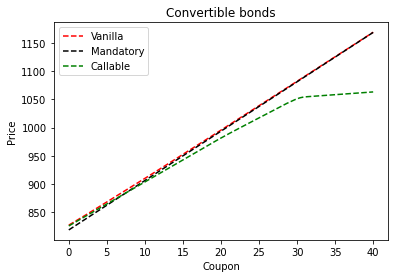

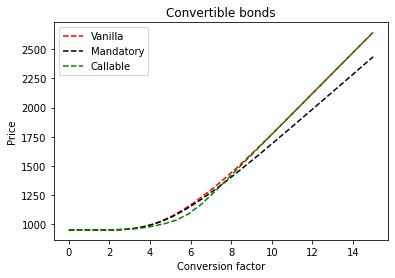

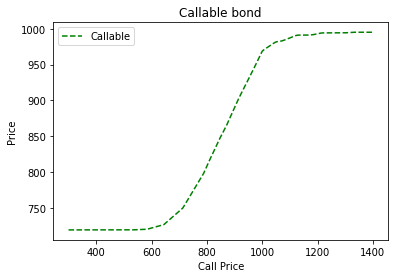

In [ ]:
#illustrates graphically how the prices of the three bonds depend on the coupon c, conversion factor beta = gamma and the call price F_c
#on the coupon we can see that 
# point 5.4 

def change_c():
  C = np.linspace(0,40,1000)  #here we calculate the price for different values of the coupon rate 
  mCB_c =[]
  for cc in C:
    mCB_c.append(main("mCB", 175, F, T, r, Delta, U, D, delta ,div_dates, coupon_dates, gamma, cc/1000, alpha, beta))
      

  CB_c =[]
  for cc in C:
     CB_c.append(main("CB", 175, F, T, r, Delta, U, D, delta ,div_dates, coupon_dates, gamma, cc/1000, False))


  cCB_c = []
  for cc in C:
    cCB_c.append(main("cCB", 175, F, T, r, Delta, U, D, delta ,div_dates, coupon_dates, gamma, cc/1000,Fc, False))


  plt.plot(C, CB_c, label = "Vanilla", color = "red",  linestyle='dashed')    #plot the results 
  plt.plot(C, mCB_c, label= "Mandatory", color = "black",  linestyle='dashed')
  plt.plot(C, cCB_c, label = "Callable", color = "green",  linestyle='dashed')

  plt.title("Convertible bonds")
  plt.legend()
  plt.xlabel("Coupon")
  plt.ylabel("Price")
  plt.show()

change_c()   #here we call the function for getting the plot 



#we do the same thing for the conversion factor 

def change_gamma():    #we want to see how the price changes when we change the conversion factor 
  ggamma = np.linspace(0.001,15,1000)   #array of conversion factor values that we calculate the price of the three securities 
  mCB_g =[]
  for g in ggamma:
    mCB_g.append(main("mCB", 175, F, T, r, Delta, U, D, delta ,div_dates, coupon_dates, g, c, alpha, g))
      

  CB_g =[]
  for g in ggamma:
    CB_g.append(main("CB", 175, F, T, r, Delta, U, D, delta ,div_dates, coupon_dates, g, c, False))
    

  cCB_g =[]
  for g in ggamma:
    cCB_g.append(main("cCB", 175, F, T, r, Delta, U, D, delta ,div_dates, coupon_dates, g, c, Fc, False))
      

  plt.plot(ggamma, CB_g, label = "Vanilla", color = "red", linestyle='dashed')
  plt.plot(ggamma, mCB_g, label = "Mandatory", color = "black", linestyle='dashed')
  plt.plot(ggamma, cCB_g, label = "Callable", color = "green",linestyle='dashed' )
  plt.title("Convertible bonds")
  plt.legend()
  plt.xlabel("Conversion factor")
  plt.ylabel("Price")
  plt.show()

change_gamma()



#function to see how the price of cCB change when we change the value of F_c

def change_FC():
  FC = [i for i in np.linspace(300,1400,1000) ]   #if you want less precision you can reduce 1000
  cCB_fc = []
  for j in FC:
    cCB_fc.append(main("cCB", 175, F, T, r, Delta, U, D, delta ,div_dates, coupon_dates, gamma, c, j, False))
      

  plt.plot(FC, cCB_fc, color = "green", label = "Callable",linestyle='dashed')
  plt.title("Callable bond")
  plt.ylabel("Price")
  plt.legend()
  plt.xlabel("Call Price")
  plt.show()

change_FC()





In [ ]:
#point 5.5
#here to increase performance we have choosen an gradient descent algorithm
#so what we did is to minimize the quadratic loss function between the price and the face value changing the coupon rate
#we move the coupon rate in the opposite direction of the gradient of the loss function 
#the gradient of the loss function (loss function  = 0.5 * (price - F)^2) is simply given by (price - F)*(derivative of price)
#here to get the derivative of price we have used as approximation (price(c+h) - price(c))/h called incremental ratio 
#then in this we have used the h for the approximation of the derivative equal to the step size that determines the movemnt of the coupon 


def c_fixed_price( sec , s0, F, T, r, Delta, u, d, div_yield,dividend_dates, coupon_dates, gamma, alpha, beta, Fc):
   
    if sec == "mCB":
        func1 = lambda cc : main("mCB", s0, F, T, r, Delta, u, d, div_yield,dividend_dates, coupon_dates, gamma, cc, alpha, beta)   
        x = 0.02       #starting point of the coupon rate 
        h = 0.00000001       #step size and value used to approximate the derivative 
        i = 0                 #counter

        while(i < 2000):
            i = i + 1  
            y0 = func1(x)      #so we calculate the function  in a given value of c  
            y1 = func1(x+h)      #function in c+h 
            x -= (y0-F)*(y1-y0)     #now we move the coupon rate in the opposite direction of the gradient multiplied by the step size 
        return y0 , x             #here we return the value of the function and the coupon rate found after 2000 iterations 


    if sec == "CB":
    
        func1 = lambda cc : main("CB", s0, F, T, r, Delta, u, d, div_yield,dividend_dates, coupon_dates, gamma, cc, False)   
        x = 0.02
        h = 0.00000001    #for a description see above 
        i = 0

        while(i < 2000):
            i = i + 1
            y0 = func1(x)
            y1 = func1(x+h)
            x = x - (y0-F)*(y1-y0)
        return y0 , x 
    
    
    if sec == "cCB":
        func1 = lambda cc : main("cCB", s0, F, T, r, Delta, u, d, div_yield,dividend_dates, coupon_dates, gamma, cc, Fc,False)   
        x = 0.02
        h = 0.00000001   #for a description of this function see above 
        i = 0

        while(i < 2000):
            i = i + 1
            y0 = func1(x)
            y1 = func1(x+h)
            x = x - (y0-F)*(y1-y0)
        return y0 , x 





g_list = [1,2,3,4,5,6]     #list of conversion factors 
res_mcb = []   #empty lists to store values 
res_cb  = []
res_ccb = []

for g in g_list:
  res_mcb.append(c_fixed_price("mCB", 175, F, T, r, Delta, U, D, delta ,div_dates, coupon_dates, g, alpha, g,Fc) )       #here we the the values to the bar plots 
  res_cb.append(c_fixed_price("CB", 175, F, T, r, Delta, U, D, delta ,div_dates, coupon_dates, g, alpha, g,Fc) )
  res_ccb.append(c_fixed_price("cCB", 175, F, T, r, Delta, U, D, delta ,div_dates, coupon_dates, g, alpha, g,Fc) )



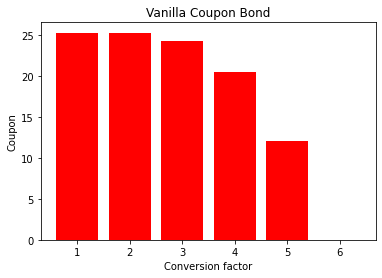

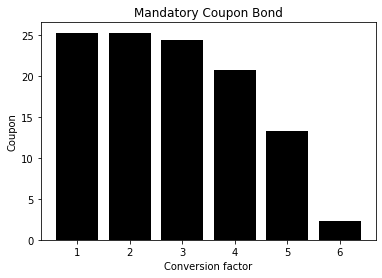

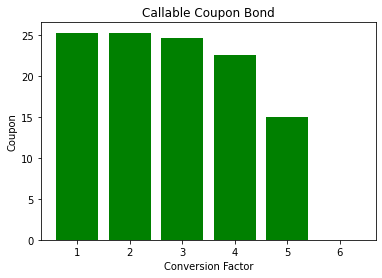




VANILLA  
 [25.31510163 25.26921572 24.36192158 20.52065994 12.02111778  0.        ]
MANDATORY  
 [25.31510169 25.26993204 24.38751468 20.72457821 13.29037653  2.27775932]
CALLABLE  
 [25.31510247 25.27978285 24.72265909 22.55866543 15.03932809  0.        ]
STANDARD BOND  
 25.3151190428326


In [ ]:
#here we produce the graphs 

cb_bar, mcb_bar, ccb_bar = [], [] ,[]

for i in range(6):     #here we put equal to 0 the coupon that comes negative 
  if res_cb[i][1] >= 0:
   cb_bar.append(res_cb[i][1])
  else: cb_bar.append(0)

  if res_mcb[i][1] >= 0:
    mcb_bar.append(res_mcb[i][1])
  else: mcb_bar.append(0)

  if res_ccb[i][1] >= 0:
     ccb_bar.append(res_ccb[i][1])
  else: ccb_bar.append(0)

#plot the bar charts 
plt.bar(x = g_list, height= np.array(cb_bar)*1000, color = "red")
plt.title("Vanilla Coupon Bond")
plt.ylabel("Coupon")
plt.xlabel("Conversion factor")
plt.show()

plt.bar(x = g_list, height = np.array(mcb_bar)*1000, color = "black")
plt.title("Mandatory Coupon Bond")
plt.ylabel("Coupon")
plt.xlabel("Conversion factor")
plt.show()


plt.bar(x = g_list, height=np.array( ccb_bar ) * 1000, color = "green")
plt.title("Callable Coupon Bond")
plt.xlabel("Conversion Factor")
plt.ylabel("Coupon")
plt.show()


#function that uses gradient descent as described before to calculate the 
def c_for_stand():
  
       func1 = lambda cc : standard_coupon_bond(r, F, Delta, T, cc, coupon_dates)
       x = 0.02
       h = 0.00000001
       i = 0

       while(i < 2000):
            i = i + 1
            y0 = func1(x)
            y1 = func1(x+h)
            x -= (y0-F)*(y1-y0)

       return y0 , x 

standard_bond_part_coupon = c_for_stand()[1]*1000


#we can also see the singluar values 
print("\n\n")
print("VANILLA  \n", np.array(cb_bar)*1000)
print("MANDATORY  \n", np.array(mcb_bar)*1000)
print("CALLABLE  \n", np.array(ccb_bar)*1000)
print("STANDARD BOND  \n", standard_bond_part_coupon)

In [ ]:
#5.6 
#here we do the same we have done before but changing the value of the conversion rate gamma 
#we apply the same gradient descent algorithm as before 


def g_fixed_price( sec , s0, F, T, r, Delta, u, d, div_yield,dividend_dates, coupon_dates,c , alpha, beta, Fc):

    if sec == "CB":
    
        func1 = lambda g : main("CB", s0, F, T, r, Delta, u, d, div_yield,dividend_dates, coupon_dates, g, c, False)   
        x = 4
        h = 0.00000001
        nu = 0.00005
        i = 0

        while(i < 2500):
            i = i + 1
            y0 = func1(x)
            y1 = func1(x+h)
            x = x - nu*(y0-F)*(y1-y0)/h
        
        return y0 , x 
    

    if sec == "cCB":
        func1 = lambda g : main("cCB", s0, F, T, r, Delta, u, d, div_yield,dividend_dates, coupon_dates, g, c, Fc,False)   
        x = 4
        h = 0.00000001
        nu = 0.00005
        i = 0

        while(i < 1000):
            i = i + 1
            y0 = func1(x)
            y1 = func1(x+h)
            x = x - nu*(y0-F)*(y1-y0)/h
        return y0 , x 



conversion_cb = g_fixed_price( "CB", 175, F, T, r, Delta, U, D, delta ,div_dates, coupon_dates, c , alpha, beta, Fc)[1]
conversion_ccb = g_fixed_price( "cCB", 175, F, T, r, Delta, U, D, delta ,div_dates, coupon_dates, c , alpha, beta, Fc)[1]
print("Vanilla:  par conversion factor: ",conversion_cb)
print("Callable: par conversion factor: ",conversion_ccb)

Vanilla:  par conversion factor:  4.093627884861063
Callable: par conversion factor:  4.521678838322443


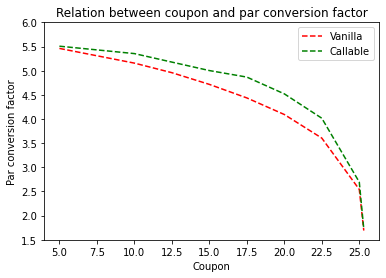

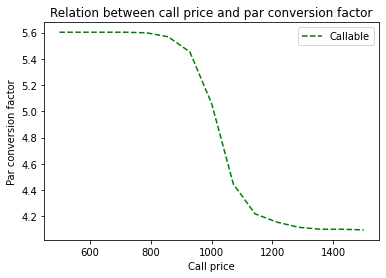

In [ ]:
#linear search for getting the conversion factor that makes the price equal to the face values 

def search_g_for_c_CCB(coupon, up, low):    #linear search for the callable coupon bond 
    ggg = np.linspace(low, up,2000)
    for i in ggg:
   
      x = main("cCB", s0, F, T, r, Delta, U, D, delta,div_dates, coupon_dates, i, coupon, Fc,False)   
      if round(x,1) == 1000.0:
        return i


def search_g_for_c_CB(coupon, up, low):   #linear search for the vanilla bond 
    ggg = np.linspace(low, up,2000)
    for i in ggg:
     
      x = main("CB", s0, F, T, r, Delta, U, D, delta,div_dates, coupon_dates, i, coupon,False)   
      if round(x,1) == 1000.0:
        return i



coupon = [0.005,0.01,0.0125,0.015,0.0175,0.02,0.0225,0.025, 0.0253]    #here we decide these values to see how the par conversion rate changes when we change the coupon rate 
val_cCB = []
i = 0
for coup in coupon:   #for each coupon here we calculate the par conversion rate andwe put them in a list 
  
  if i > 0: 
    j = (search_g_for_c_CCB(coup, j, j-2))
    val_cCB.append(j)
    i = i + 1
  else: 
    j = (search_g_for_c_CCB(coup, 6, 4))
    val_cCB.append(j)
    i = i+1
 
 

val_CB = []    
i = 0
for coup in coupon:     #for each coupon here we compute the par conversion value and we put them in a list 
  
  if i > 0: 
    j = (search_g_for_c_CB(coup, j, j-2))
    val_CB.append(j)
    i = i + 1
  else: 
    j = (search_g_for_c_CB(coup, 6, 4))
    val_CB.append(j)
    i = i+1


plt.plot(np.array(coupon)*1000, val_CB, color = "red", linestyle='dashed', label = "Vanilla" )
plt.plot(np.array(coupon)*1000, val_cCB, color = "green", linestyle='dashed', label = "Callable" )

plt.ylim(1.5,6)
plt.legend()
plt.title("Relation between coupon and par conversion factor")
plt.xlabel("Coupon")
plt.ylabel("Par conversion factor")
plt.show()


#here we develop this function to see how the par conversion function changes when we change the call price 


c = 0.02                                             #coupon rate 
F_list = [i for i in np.linspace(500,1500,15) ]      #list for all the Call price that we get the par coupon factor 
ccb_conv_to_f = []
for f in F_list:
      ccb_conv_to_f.append( g_fixed_price( "cCB", 175, F, T, r, Delta, U, D, delta ,div_dates, coupon_dates, c , alpha, beta, f)[1] )   #here we calculate the par conversion factor for each coupon 


plt.plot(F_list, ccb_conv_to_f, color = "green", linestyle='dashed', label = "Callable" )
plt.title("Relation between call price and par conversion factor")
plt.xlabel("Call price")
plt.legend()
plt.ylabel("Par conversion factor")
plt.show()
